In [102]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime

date_from = date(2021,11,23)

In [12]:
#data downloaded from Appointments edited version for previous two days

csv_address = 'C:\\Users\\RichardKim\\Downloads\\query_result_2021-11-25T12_30_22.150058-08_00.csv'

In [13]:
def Accessioning_Shift(hr):
    if hr in range(6, 14): return 'AM'
    elif hr in range(14, 22): return 'PM'
    else: return 'GY'

def Accessioning_Shift2(hours):
    if int(hours[-2:]) in range(6, 14): return 'AM'
    elif int(hours[-2:]) in range(14, 22): return 'PM'
    else: return 'GY'

#AM : lightgreen
#PM : lightcoral
#GY : skyblue

def Shift_color(shift):
    if shift == 'AM': return 'lightgreen'
    elif shift == 'PM': return 'lightcoral'
    elif shift == 'GY': return 'skyblue'
    else: return 'black'

#used for x-axis tick marks
def Adj_hours(hours):
    if hours[-2:] == '00': return hours
    elif int(hours[-2:]) % 3 == 0: return hours[-2:]
    return ''

In [31]:
cutoff = pd.to_datetime('2021-11-24 12:00:00-08:00')
cutoff

Timestamp('2021-11-24 12:00:00-0800', tz='pytz.FixedOffset(-480)')

In [32]:
df = pd.read_csv(csv_address)

df.rename(columns = dict(zip(df.columns, map(lambda x: x.replace(' ', '_'), df.columns))), inplace = True)
for column_name in ['Accessioned_At', 'Completed_At', 'In_Testing_At', 'Pulled_At', 'Released_At', 'Resulted_At', 'Updated_At']:
    df[column_name] = pd.to_datetime(df[column_name])

##############
df = df.loc[df['Completed_At'] > cutoff]
##############
df['Completed_Date'] = df['Completed_At'].dt.date
df['Completed_Hour'] = df['Completed_At'].dt.hour

min_date = str(min(df.Completed_Date))
max_date = str(max(df.Completed_Date))

#dropping rows where the samples never went into testing i.e. In_Testing_At value is NaT
df = df[df['In_Testing_At'].notna()]

df['Time_Taken_From_Accessioning_To_Testing'] = df['In_Testing_At'] - df['Accessioned_At']
df['Time_AtoT_In_Hours'] = df['Time_Taken_From_Accessioning_To_Testing'].apply(pd.Timedelta.total_seconds)/3600

df['Time_Taken_From_Completion_To_Accessioning'] = df['Accessioned_At'] - df['Completed_At']
df['Time_CtoA_In_Hours'] = df['Time_Taken_From_Completion_To_Accessioning'].apply(pd.Timedelta.total_seconds)/3600

AttributeError: Can only use .dt accessor with datetimelike values

In [ ]:
df3 = df.loc[df['Completed_Date'] >= date_from]
average_df = df3[['Completed_Date', 'Completed_Hour', 'Time_CtoA_In_Hours', 'Time_AtoT_In_Hours', 'ID']] \
            .rename(columns = {'ID': 'Sample_Count'})\
            .groupby(by=[df3.Completed_Date, df.Completed_Hour])\
            .agg({'Time_CtoA_In_Hours' : np.median,
                  'Time_AtoT_In_Hours' : np.median,
                  'Sample_Count': 'size'})
average_df['hours'] = list(map(lambda x: str(x[0]) + ' ' + f'{x[1]:>02}', average_df.index))
average_df = average_df.set_index('hours')

min_dt = datetime(min(df3.Completed_At).year, min(df3.Completed_At).month, 
                  min(df3.Completed_At).day, min(df3.Completed_At).hour)
max_dt = datetime(max(df3.Completed_At).year, max(df3.Completed_At).month, 
                  max(df3.Completed_At).day, max(df3.Completed_At).hour)

min_date = str(min(df3.Completed_Date))
max_date = str(max(df3.Completed_Date))

total_hours = int((max_dt - min_dt).total_seconds())//3600
hours_range = [f'2021-11-{d} {hr:>02}' 
               for d in range(min(df3.Completed_At).day, max(df3.Completed_At).day+1) 
               for hr in range(0,24)][:total_hours+1]
dummy = pd.DataFrame.from_dict({'hours': hours_range, 
                                'Time_CtoA_In_Hours': np.full(len(hours_range),np.nan), 
                                'Time_AtoT_In_Hours': np.full(len(hours_range),np.nan),
                                'Sample_Count': np.full(len(hours_range),np.nan)})
dummy = dummy.set_index('hours')
average_df = dummy.combine_first(average_df).fillna(0)
average_df = average_df.reset_index()

average_df['adj_hours']   = average_df['hours'].apply(Adj_hours)

In [ ]:
average_df

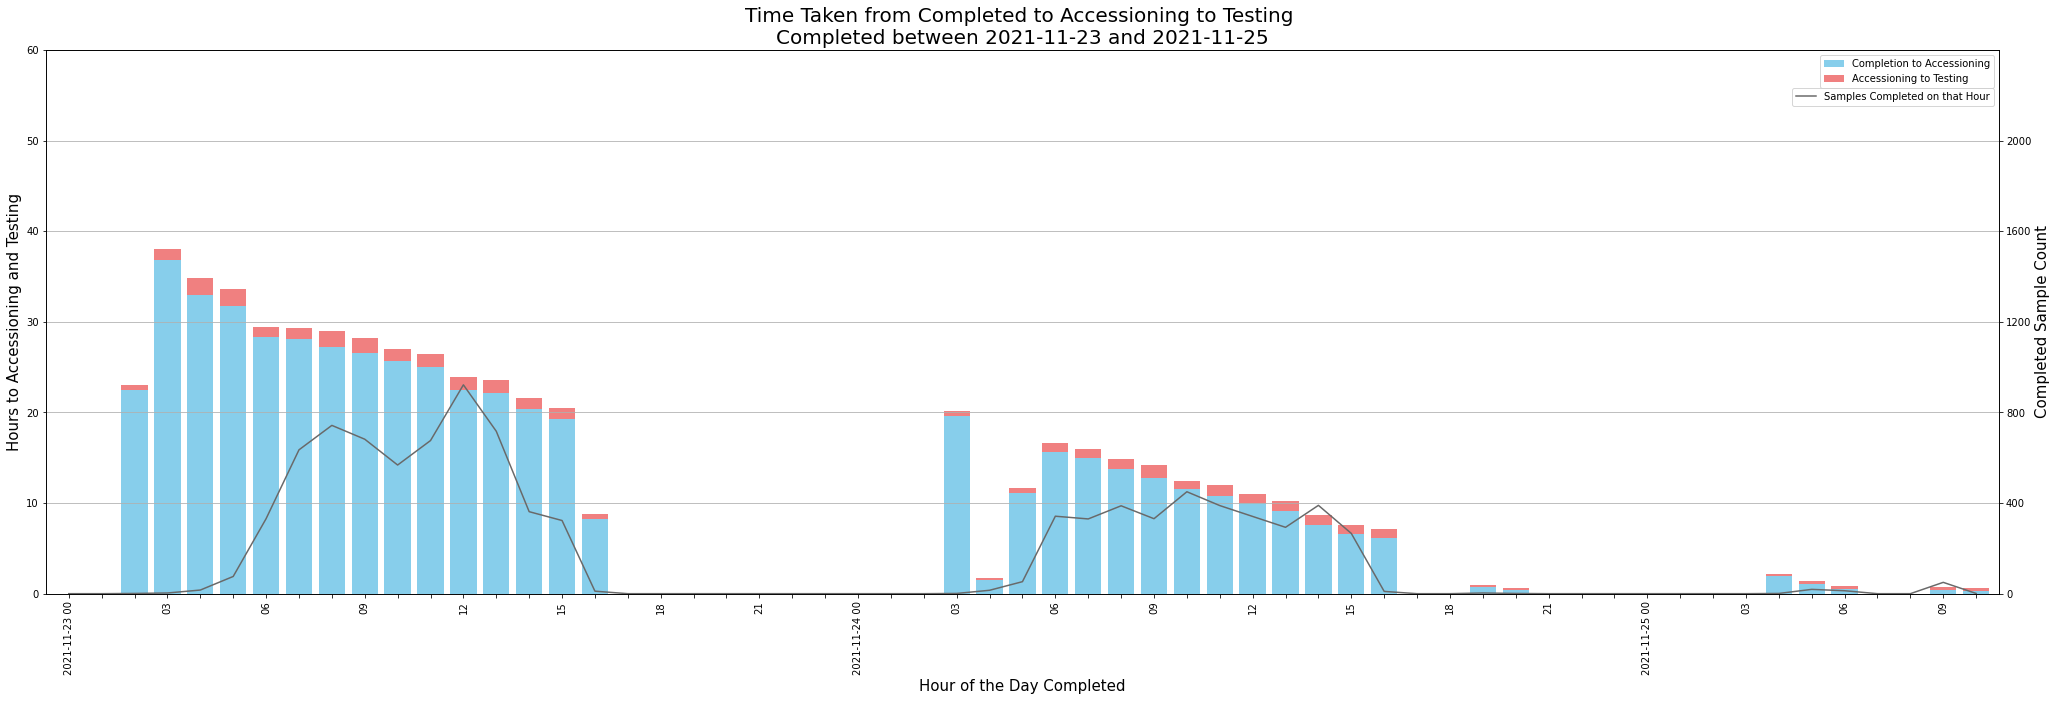

In [11]:
fig, ax1 = plt.subplots(figsize = (35,10), facecolor = 'white')

ax1.bar(average_df.hours, average_df.Time_CtoA_In_Hours, 
        label = 'Completion to Accessioning', color = 'skyblue')
ax1.bar(average_df.hours, average_df.Time_AtoT_In_Hours, 
        bottom = average_df.Time_CtoA_In_Hours, label = 'Accessioning to Testing', color = 'lightcoral')

ax1.set_xlabel('Hour of the Day Completed', fontsize = 15)
ax1.set_ylabel('Hours to Accessioning and Testing', fontsize = 15)

ax1.set_xticks(ticks = average_df.hours)
ax1.set_xticklabels(labels = average_df.adj_hours, rotation = 90)
ax1.set_xmargin(0.005)

ylim_topbound = 60

ax1.set_ylim(bottom = 0, top = ylim_topbound)
ax1.yaxis.grid(True)

ax2 = ax1.twinx()

ax2.set_ylabel('Completed Sample Count', fontsize = 15)
ax2.plot(average_df.hours, average_df.Sample_Count, 
         color = 'dimgrey', label = 'Samples Completed on that Hour')

ax2.set_xmargin(0.005)
ax2.set_xticks(ticks = average_df.hours)
ax2.set_xticklabels(labels = average_df.adj_hours, rotation = 90)

ax2.set_yticks(ticks = range(0, ylim_topbound*40, 400))
ax2.set_ylim(bottom = 0, top = ylim_topbound*40)

ax1.legend(loc=1)
ax2.legend(loc=1, bbox_to_anchor = (1, 0.94))

plt.title(f'Time Taken from Completed to Accessioning to Testing \nCompleted between {min_date} and {max_date}', fontsize=20)

plt.show()